In [11]:
import os

import pandas as pd
import numpy as np

import datetime
from datetime import timedelta

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})
%matplotlib inline

%reload_ext autoreload
%autoreload 2

import scipy ; print("scipy v." + str(scipy.__version__))
from scipy.fft import rfft, rfftfreq # FastFourrierTransform on Real input

from my_TS_Anomaly_lib.utils import millify

import pymongo ; print("pymongo v." + str(pymongo.version))
from pymongo import MongoClient, ASCENDING

scipy v.1.5.2
pymongo v.3.11.0


# MONGODB

In [12]:
# Launch the mongoDB local server instance (from command shell on Mongo DB server)
# "C:\Program Files\MongoDB\Server\4.4\bin\mongod.exe" --dbpath="D:\mongodb_data_dir" --bind_ip 127.0.0.1 --auth

Get a connection from Python Jupyter Notebook&nbsp;:

In [13]:
username = 'myAdmin'
password = 'my_admin_password'

client = MongoClient('mongodb://%s:%s@127.0.0.1' % (username, password)
                     , appname='NASA IMS')

In [14]:
database_name = 'nasa_ims_database'

In [15]:
client[database_name].measurements.index_information()

{'_id_': {'v': 2, 'key': [('_id', 1)]},
 'test_id_idx': {'v': 2, 'key': [('test_id', -1)], 'background': True},
 'timestamp_idx': {'v': 2, 'key': [('timestamp', -1)], 'background': True}}

<hr style="height:2px;border-width:0;color:gray;background-color:gray;width:80%" />

looking into a few days of test &#35;3 data (during which some spikes are observed on 'sensor_2' timestamp.abs().mean())&nbsp;:

In [16]:
cursor = client[database_name].measurements.aggregate([
    {'$match': {
        'test_id': 3
            , "timestamp": {
               "$gte": pd.DatetimeIndex(['2004-03-14 00:00:00'])[0]
               , "$lte": pd.DatetimeIndex(['2004-03-17 00:00:00'])[0] #datetime.datetime(2004, 3, 21)
            }
    }}
    , { "$project": {
        "_id": 0
        , "timestamp": 1
        , "step": 1
        , 'sensor_1': 1
        , 'sensor_2': 1
    } }
])
data = pd.DataFrame(list(cursor))

In [17]:
data.sort_values(by=['timestamp', 'step'], inplace=True)
data.reset_index(drop=True, inplace=True)

In [18]:
second_slices_count = 20479
def datetime_slice_function(df_row) :
    return df_row['timestamp'] + \
           timedelta(seconds = df_row['step']/second_slices_count)
data['long_datetime'] = data[['timestamp', 'step']].apply(datetime_slice_function, axis=1)

In [19]:
print(data.shape)
data.columns

(8335360, 5)


Index(['timestamp', 'step', 'sensor_1', 'sensor_2', 'long_datetime'], dtype='object')

In [20]:
data['timestamp'][data['timestamp'].shape[0]-1] - data['timestamp'][0]

Timedelta('2 days 23:52:34')

In [21]:
set(np.hstack(list(data['timestamp'].unique())).astype('datetime64[D]'))

{numpy.datetime64('2004-03-14'),
 numpy.datetime64('2004-03-15'),
 numpy.datetime64('2004-03-16')}

# test &#35;3 missing data points

Within the few days on which we focus here, there is one chunk of missing data points as can be observed on both 'sensor_1' and 'sensor_2' plots below&nbsp;:

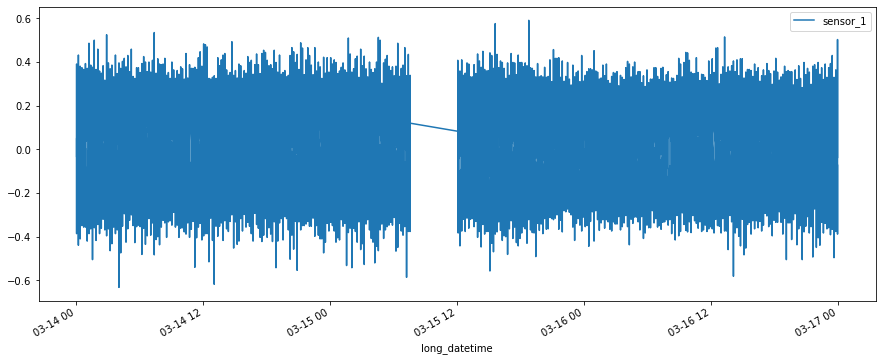

In [15]:
fig = plt.figure(figsize=(15, 6))
ax = fig.gca()
data.plot(x='long_datetime', y='sensor_1', ax=ax)
plt.show()

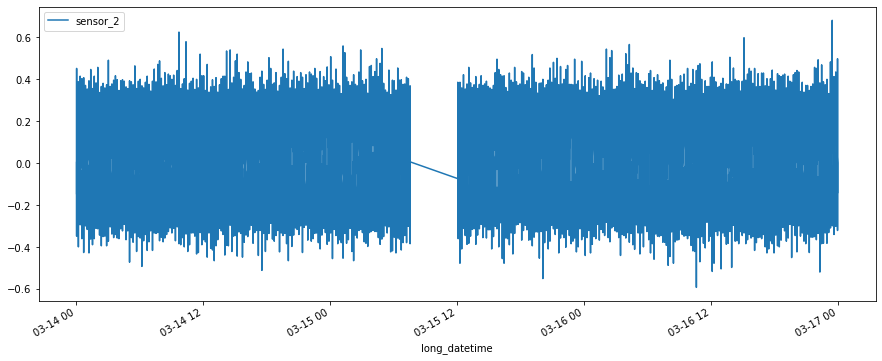

In [13]:
fig = plt.figure(figsize=(15, 6))
ax = fig.gca()
data.plot(x='long_datetime', y='sensor_2', ax=ax)
plt.show()

Missing test &#35;3 data points, looking into consequences on the "timestamp.abs().mean()" transformation => doesn't explain the spikes on 'sensor_2', since they occured at different timestamps as is clear on the below 2 figures (one for 'sensor_1', the other for 'sensor_2) where time slice with missing data points occur BEFORE the 3 spikes of 'sensor_2'&nbsp;:

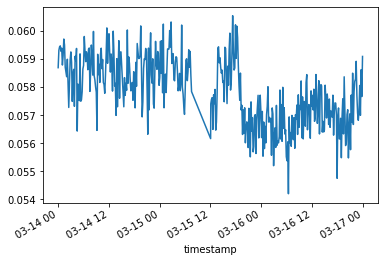

In [24]:
data.groupby(['timestamp'])['sensor_1'].apply(lambda x : x.abs().mean()).plot()

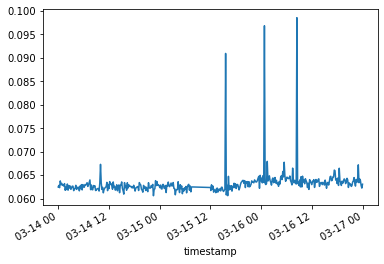

In [23]:
data.groupby(['timestamp'])['sensor_2'].apply(lambda x : x.abs().mean()).plot()

<hr style="height:2px;border-width:0;color:gray;background-color:gray;width:80%" />

# Investigate test &#35;3 'sensor_2' timestamp.abs().mean() spikes

For test #3, compare signal spectres for same timestamp between 'sensor_1' and 'sensor_2' when 'sensor_2' shows a spike (on timestamp.abs().mean())&nbsp;:

In [23]:
timestamp = pd.DatetimeIndex(['2004-03-15 15:35:20'])[0] #datetime.datetime(2004, 3, 21)

cursor = client[database_name].measurements.aggregate([
    {'$match': {
        'test_id': 3
            , "timestamp": timestamp
    }}
    , { "$project": {
        "_id": 0
        , "timestamp": 1
        , "step": 1
        , 'sensor_1': 1
        , 'sensor_2': 1
    } }
])
data = pd.DataFrame(list(cursor))

data.sort_values(by=['timestamp', 'step'], inplace=True)
data.reset_index(drop=True, inplace=True)

from datetime import timedelta
second_slices_count = 20479
def datetime_slice_function(df_row) :
    return df_row['timestamp'] + \
           timedelta(seconds = df_row['step']/second_slices_count)
data['long_datetime'] = data[['timestamp', 'step']].apply(datetime_slice_function, axis=1)

scipy v.1.5.2


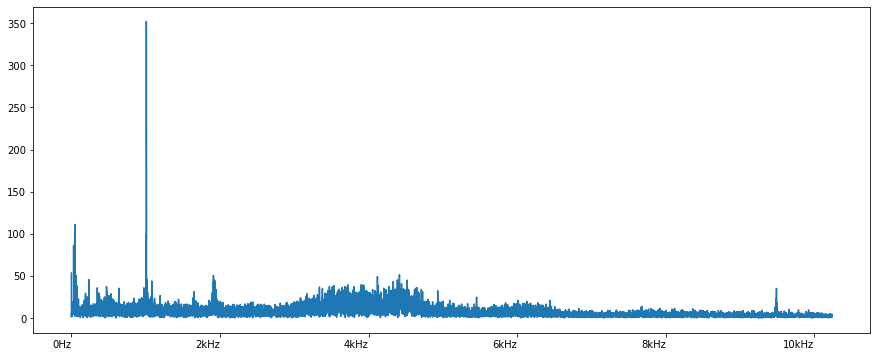

In [48]:
# sample frequencies of the measuring device (in Hertz)
# (in our case, each measurement lasts 1 second) =>
SAMPLE_RATE = second_slices_count+1

xf = rfftfreq(second_slices_count+1, 1 / SAMPLE_RATE)

fig = plt.figure(figsize=(15, 6)) ; ax = fig.gca()
yf = rfft(data[data['timestamp'] == timestamp]['sensor_1'].values)
ax.plot(xf, abs(yf))
#ax.margins(x=0, y=0)
xticks = [millify(xtick, True)+'Hz' for xtick in ax.get_xticks()]
ax.set_xticklabels(xticks, rotation=0, ha='right')
plt.show()

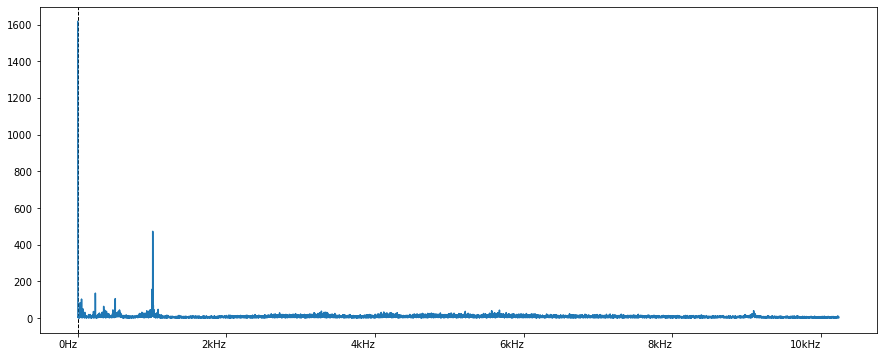

In [49]:
fig = plt.figure(figsize=(15, 6)) ; ax = fig.gca()
yf = rfft(data[data['timestamp'] == timestamp]['sensor_2'].values)
ax.axvline(0, color='k', linestyle='--', lw=1)
ax.plot(xf, abs(yf))
#ax.margins(x=0, y=0)
xticks = [millify(xtick, True)+'Hz' for xtick in ax.get_xticks()]
ax.set_xticklabels(xticks, rotation=0, ha='right')
plt.show()

0Hz signal component == constant == avg of the signal in the time domain.

Looking into a 'sensor_2' spike on timestamp.abs().mean() on test #3, (timestamp just before spike, timestamp with spike, timestamp right after spike)&nbsp;:

In [53]:
cursor = client[database_name].measurements.aggregate([
    {'$match': {
        'test_id': 3
            , "timestamp":  {
               "$gte": pd.DatetimeIndex(['2004-03-15 15:25:20'])[0]
               , "$lte": pd.DatetimeIndex(['2004-03-15 15:45:20'])[0] #datetime.datetime(2004, 3, 21)
            }
    }}
    , { "$project": {
        "_id": 0
        , "timestamp": 1
        , "step": 1
        , 'sensor_1': 1
        , 'sensor_2': 1
    } }
])
data = pd.DataFrame(list(cursor))

data.sort_values(by=['timestamp', 'step'], inplace=True)
data.reset_index(drop=True, inplace=True)

second_slices_count = 20479
def datetime_slice_function(df_row) :
    return df_row['timestamp'] + \
           timedelta(seconds = df_row['step']/second_slices_count)
data['long_datetime'] = data[['timestamp', 'step']].apply(datetime_slice_function, axis=1)

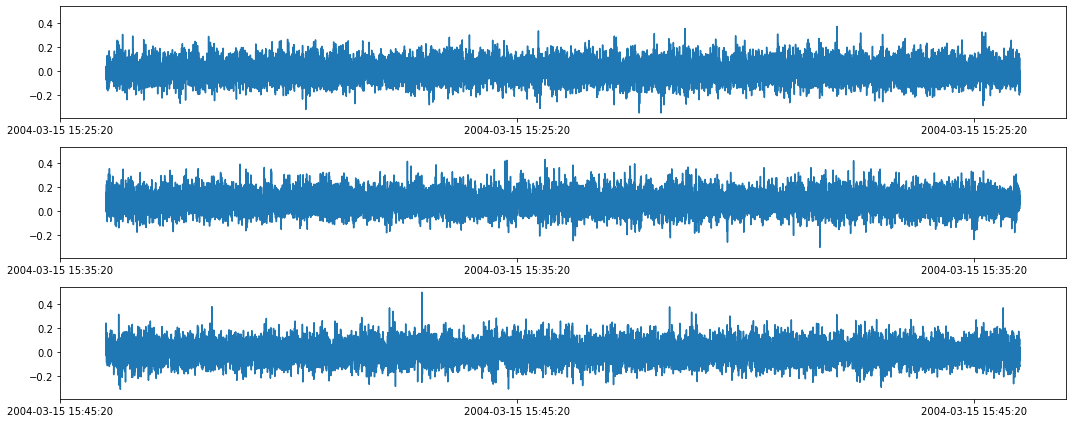

In [56]:
timestamps = pd.DatetimeIndex(data['timestamp'].unique()).sort_values(ascending = True)

fig, ax = plt.subplots(len(timestamps), 1, figsize=(15, 6), sharey = 'all')
fig.subplots_adjust(hspace = .5, wspace=.001)
ax = ax.ravel()

for i, timestamp in enumerate(timestamps) :
    data[data['timestamp'] == timestamp] \
        .plot('long_datetime', [sensor_name], ax = ax[i])
    ax[i].get_legend().remove()
    ax[i].set_xlabel(None)
    ax[i].set_xticklabels([timestamp]*len(ax[i].get_xticklabels())
                          , rotation=0, ha='center')
fig.tight_layout() ; plt.show()

Notice above that the middle measurement has a tiny offset (~0.1) compared to the two surrounding ones (just before and just after).

<br />
<br />
<br />
<center><b><font size=14pt>THE END.</font></b></center>
<br />
<br />
<br />

<hr style="height:2px;border-width:0;color:gray;background-color:gray;width:80%" />

# EXTRA

<b>Export Notebook to HTML (with Markdown extension cells evaluated and hidden cell outputs omitted)&nbsp;:</b>

In [1]:
import os ; from my_TS_Anomaly_lib.utils import get_notebook_fullname
get_notebook_fullname()

'D:\\jupyter_notebooks\\TimeSeries_Anomaly_Detection\\mongo_test3_sensor2_spikes.ipynb'

<em>(to be launched from the conda env which holds the Jupyter installation, the one named '<b>r-tensorflow</b>', in our personal case)</em>
<br />
<br />
<code>
<br />
conda activate r-tensorflow
python
<br />
import os ; os.getcwd()
os.chdir('{{os.path.realpath('.')}}') # to set working dirctory
from my_TS_Anomaly_lib.jupyter_markdown_extension import md_extension_to_html
md_extension_to_html('{{get_notebook_fullname()}}')
<br />
</code>
"Ctrl+D" (to exit python console mode)

<hr style="height: 4px; width: 70%; margin:0 auto;" />